# Thông tin thành viên nhóm:
- **Nguyễn Huy Hải – 18120023**
- **Phạm Công Minh – 18120058**
- **Nguyễn Thanh Tùng – 181201048**
- **Nguyễn Thị Hồng Nhung – 18120498**

# Import thư viện

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

import time

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#Create Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#Lưu model
import pickle

---

# Tập dữ liệu MNIST

## Tải tập dữ liệu

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

- Tập X có bao nhiêu dòng cột

In [3]:
X.shape

(70000, 784)

- Tập y có bao nhiêu dòng

In [4]:
y.shape

(70000,)

### Hàm xóa bỏ tất cả các cột, dòng bằng 0 và chỉnh kích thước thành (28,28)

In [5]:
class Image_Filter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sum_delete_pixel = 0
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_adj = []
        delete_pixel = np.zeros((X.shape[0],1), dtype = int)
        for i in range(len(X)):
            img = X[i].reshape((28, 28))
            # Xoa dong, cot trong
            index_col = np.any(img != 0, axis=0)
            img = img[:, index_col]
            index_row = np.any(img != 0, axis=1)
            img = img[index_row]
            data = cv.resize(img, dsize=(28, 28), interpolation=cv.INTER_CUBIC)
            data = data.reshape(X.shape[1])
            X_adj.append(data)
            delete_pixel[i] = 784 - img.shape[0]*img.shape[1]
        X_adj=np.array(X_adj)
        X_adj = X_adj.reshape(X_adj.shape[0],-1)
        self.sum_delete_pixel = np.sum(delete_pixel)
        return X_adj

### Hàm xoay ảnh

In [6]:
def sharpening(X, tol, add):
    X_copy = X.copy()
    X_copy[X_copy>0] = X_copy[X_copy>0] + add
    X_copy[X_copy>255] = 255
    X_copy[X_copy<tol] = 0 
    return X_copy

def rotate_image(X, h, w, angle):
    image = X.reshape(h, w)
    center = (w / 2, h / 2)  
    M = cv.getRotationMatrix2D(center, angle, 1.0)  
    rotated_image = cv.warpAffine(image, M, (h, w))
    rotated_image =  sharpening(rotated_image.reshape(-1), 100, 40)   
    return rotated_image

def crete_rotated_sample(X, y, angle):
    X_rotated = np.apply_along_axis(rotate_image, axis=1, arr=X, h=28, w=28, angle=angle)
    y_rotated = y
    return X_rotated, y_rotated

---

# Huấn luyện trên toàn bộ dữ liệu:

- Tạo ra các ảnh được xoay từ tập dữ liệu 
- xoay 4 lần với các góc: [10, -10, 5, -5]

In [7]:
angle = [10, -10, 5, -5]
X_rotated, y_rotated = crete_rotated_sample(X, y, angle[0])
X_temp = X_rotated
y_temp = y_rotated
for i in range(1, len(angle)):
    X_rotated, y_rotated = crete_rotated_sample(X, y, angle[i])
    X_temp = np.concatenate((X_rotated, X_temp), axis=0)
    y_temp = np.concatenate((y_rotated, y_temp), axis=0)

- Thêm vào dữ liệu các ảnh đã được xoay

In [8]:
X = np.concatenate((X, X_temp), axis=0)
y = np.concatenate((y, y_temp), axis=0)

- Tập X có bao nhiêu dòng sau khi thêm ảnh đã xoay

In [9]:
X.shape

(350000, 784)

- Tập y có bao nhiêu dòng sau khi thêm ảnh đã xoay

In [10]:
y.shape

(350000,)

- Tạo pipeline

In [11]:
pipeline = Pipeline([('image_filter', Image_Filter()),
                     ('pca', PCA(n_components= 70, svd_solver="randomized", random_state = 0)),
                     ('poly', PolynomialFeatures(include_bias = True, interaction_only= True)),
                     ('scaler', StandardScaler()), 
                     ('classifier', LogisticRegression(penalty='l2', solver='saga', tol=0.01, random_state = 0))])

- Huấn luyện mô hình

In [16]:
pipeline.fit(X, y)

score = pipeline.score(X, y)
print("Train score with L2 penalty: %.4f" % score)

Train score with L2 penalty: 0.9986


- Confusion Matrix

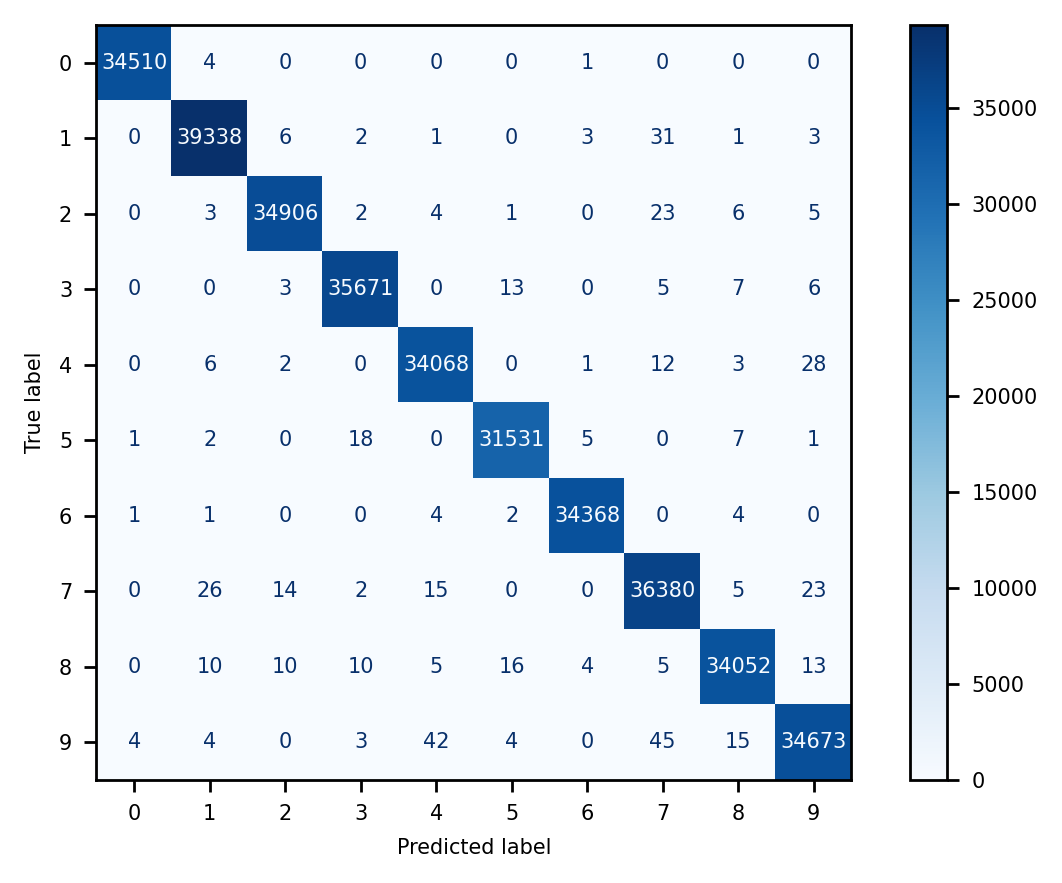

In [17]:
predict_y = pipeline.predict(X)
label = np.unique(y)
Confusion_Matrix = confusion_matrix(y, predict_y)
plt.figure(dpi=250)
plt.rcParams.update({'font.size': 6})
axes = plt.axes()
cm_display = ConfusionMatrixDisplay(Confusion_Matrix, label).plot(cmap='Blues',values_format='', ax = axes)

- Độ chính xác của mỗi lớp

In [18]:
print(classification_report(y, predict_y, target_names=label, digits=6))

              precision    recall  f1-score   support

           0   0.999826  0.999855  0.999841     34515
           1   0.998578  0.998807  0.998693     39385
           2   0.998998  0.998741  0.998870     34950
           3   0.998964  0.999048  0.999006     35705
           4   0.997920  0.998476  0.998198     34120
           5   0.998860  0.998923  0.998891     31565
           6   0.999593  0.999651  0.999622     34380
           7   0.996685  0.997669  0.997177     36465
           8   0.998592  0.997861  0.998226     34125
           9   0.997727  0.996637  0.997182     34790

    accuracy                       0.998563    350000
   macro avg   0.998574  0.998567  0.998570    350000
weighted avg   0.998563  0.998563  0.998563    350000



- Ghi pipeline ra file

In [19]:
pickle.dump(pipeline, open('pipeline_LR.sav', 'wb'))